# Data Exploration for Green Roof Diagnostics

The purpose of this notebook is to find the "linear reservoir coefficients", essentially a "water balance" approach to looking at the StormWatch data.  We want to understand which independent variables strongly affect the dependent variable of absorption.  Absorption being the green roof holds holds onto water, even for one increment.  

Independent Variables in data set suspected to significantly affect absorption:
- AMC (antecedent moisture condition)
- Thickness of soil
- Thickness of retention layer
- Type of drainage layer
- Slope
- Intensity of rainfall

Independent Variables NOT in data set suspected to significantly affect absorption:
- Capillarity of soil (currently all the same)
- Capillarity of retention layer (currently all the same)
- Capillary differential between soil and retention layer (currently all the same)
- Permeability of soil (currently all the same)
- Transmissivity of drainage layer (we have a few different types)

Independent Variables in data set suspected NOT to significantly affect absorption:
- Plant coverage or health (suspected to strongly affect evapotranspiration, but not absorption)
- Surface roughness (same in all cases, suspected only to impact sheet flow, of which we have little)
- Surface slope (same as overall slope)

What we need to confirm:
Is the first group correct? I.e. does each variable significantly affect absorption?
What is the weight of each variable in the first group?

This notebook uses data collected from a second SQL download of GRD's database. This notebook will build upon information learned from its first version, mainly that models designed to predict absorption work much better when using the variable absorb_delta_in as the response variable. In addition, the effect of the drainage layer on absorption percentage will be shown through visualizations. Lastly, variables shown to have little effect on absorption will be removed from the model at each tier so as to find how variable importance changes in these tiers.   

## Data Engineering

The test, labhifreq, cassettes and profiles tables will be joined. Then, in order to eliminate rows where the data logger was on but not collecting relevant data, the rows where the id_test value is null will be dropped. Secondly, tests 13, 15, 21, 22, 109, 170, and 217 will be dropped, as there were errors in these tests. Finally, all rows with mins_total from 1-4 will be dropped. The reason for removing these rows is that the data may be incorrect in this range, as the instruments may be callibrating:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import math
import seaborn as sns 
# import labhifreq
path_labhifreq = r'/Users/kyleknoebel/Desktop/Green_Roof_Diagnostics/CSVs-3-20-19(Second Analysis)/labhifreq2.csv'
labhifreq = pd.read_csv(path_labhifreq)
# drop rows where id_test is null
labhifreq = labhifreq[~labhifreq['id_test'].isnull()]
# drop columns shared with test.csv
labhifreq = labhifreq.drop(['timestamp_created', 'id_storm', 'notes', 'bad_data', 'panel_temp_c', 
                            'rain_temp_c'], 1)
# reset index of labhifreq to id_test for join
labhifreq = labhifreq.reindex()
# import test table
path_tests = r'/Users/kyleknoebel/Desktop/Green_Roof_Diagnostics/CSVs-3-20-19(Second Analysis)/tests2.csv'
tests = pd.read_csv(path_tests)
# join test and labhifreq tables
df = tests[['id_test', 'id_cassette', 'runoff_rate_peak_reduction_pct', 'absorb_peak_pct', 
            'slope_pct']].merge(labhifreq, on='id_test')
# import cassettes
path_cassettes = r'/Users/kyleknoebel/Desktop/Green_Roof_Diagnostics/CSVs-3-20-19(Second Analysis)/cassettes2.csv'
cassettes = pd.read_csv(path_cassettes)
# drop all except connectors 
cassettes = cassettes[['id_cassette', 'id_profile']]
# join cassette and df tables
df = df.merge(cassettes, on='id_cassette')
# import platforms
path_profiles = r'/Users/kyleknoebel/Desktop/Green_Roof_Diagnostics/CSVs-3-20-19(Second Analysis)/profiles2.csv'
profiles = pd.read_csv(path_profiles)
# drop redundant columns
profiles = profiles[['id_profile', 'media_thickness_in', 'retention_thickness_in',
                         'profile_max_vwc_pct', 'drain_type', 'drain_type_num']]
# join platform and df
df = df.merge(profiles, on='id_profile')
# drop rows from 0-4 mins
df = df[~(df.iloc[:, 17]<5)] 
# drop null values 
df = df.dropna()
# show high level statistical summary
df.describe()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id_test,id_cassette,runoff_rate_peak_reduction_pct,absorb_peak_pct,slope_pct,id,id_cr6,reservoir_rain_lbs_avg,cassette_lbs_avg,reservoir_sheet_lbs_avg,...,runoff_gals_total,runoff_lbs_total,runoff_in_total,absorb_delta_in,absorb_delta_gals,id_profile,media_thickness_in,retention_thickness_in,profile_max_vwc_pct,drain_type_num
count,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,...,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000,33268.000000
mean,137.079776,42.402639,0.086672,6.039982,0.011118,240684.012685,32876.643591,1207.927269,2613.370501,3.764551,...,73.580962,613.665122,1.491720,0.000256,0.012731,50.851960,2.217702,0.891878,0.453614,63.565589
std,62.342307,8.784480,0.115063,32.824897,0.010936,67318.555482,19300.463679,408.364321,474.895880,10.815039,...,44.752277,373.234060,0.906396,0.009112,0.453765,6.699359,1.053489,0.575292,0.083427,45.076862
min,22.000000,16.000000,-0.064400,0.001400,0.000000,122029.000000,110.000000,301.500000,1.167000,-1.500000,...,-2.423300,-20.210000,-0.049000,-0.065007,-3.237410,24.000000,0.810000,0.000000,0.261200,5.000000
25%,84.000000,39.000000,0.025600,1.036200,0.000000,176020.750000,20582.000000,1049.750000,2164.000000,0.000000,...,49.265600,410.875000,0.998800,-0.002408,-0.119904,46.000000,0.940000,1.000000,0.414400,5.000000
50%,146.000000,42.000000,0.063700,1.561900,0.020000,243067.500000,26185.000000,1294.000000,2714.000000,0.500000,...,65.527600,546.500000,1.329300,0.000000,0.000000,52.000000,2.610000,1.000000,0.453100,100.000000
75%,196.000000,46.000000,0.109400,3.109500,0.020000,307730.250000,51996.250000,1404.000000,2967.000000,2.000000,...,89.256600,744.400000,1.809925,0.000000,0.000000,55.000000,2.730000,1.000000,0.489200,100.000000
max,216.000000,54.000000,0.991700,526.315800,0.025000,333058.000000,72170.000000,2157.000000,3508.000000,76.000000,...,166.846600,1391.500000,3.381500,0.077046,3.836930,58.000000,4.500000,2.000000,0.635600,100.000000


Previous analysis by the Green Roof Diagnostics team has shown 3 distinct groups in the data, categorized by saturation percentage (sat_pct):

1) 0-33%

2) 34-66%

3) 67% and greater

Below three tiers will be created to select for these saturation percentages. 

In [2]:
# first tier
first_tier = df[df['sat_pct']<=0.3333]
# second tier
second_tier = df[(df['sat_pct']>0.3333) & (df['sat_pct']<=0.6666)]
# third tier
third_tier = df[df['sat_pct']>0.6666]

# Data Exploration

## t-SNE 

The variables in the data have a non-linear relationship, so PCA cannot be used to reduce dimensionality. As such, a [t-distributed Stochastic Neighbor Embedding](https://lvdmaaten.github.io/tsne/) model will be used to map the data and reduce dimensionality. t-SNE is a 'black box' method, meaning its algorithm cannot be analyzed, and as it reduces dimensionality it transforms all features in the data so the original variables cannot be ranked. It will be used here to provide visualization of the variables chosen for analysis.   

In [3]:
# show values in profile_max_vwc_pct column
df['profile_max_vwc_pct'].value_counts()

0.4461    6134
0.4892    5484
0.4531    3901
0.5321    3726
0.3515    3584
0.6356    2153
0.5173    2132
0.4144    1937
0.2612    1851
0.3938    1190
0.3651     787
0.3812     389
Name: profile_max_vwc_pct, dtype: int64

The null values in the profile_max_vwc_pct column have been filled, so this variable can be used in the new t-SNE model.

In [4]:
# create dataframe for the tsne model
tsne_data = df[['id_profile', 'runoff_rate_peak_reduction_pct', 'slope_pct', 'cassette_lbs_avg', 'rain_in', 
                'amc_pct', 'vwc_pct', 'runoff_trans_in', 'profile_max_vwc_pct', 'runoff_sheet_in', 
                'water_lbs_overspray_expected', 'sat_pct', 'runoff_in', 'media_thickness_in', 
                'retention_thickness_in', 'drain_type_num']]
# show format
tsne_data.head()

,id_profile,runoff_rate_peak_reduction_pct,slope_pct,cassette_lbs_avg,rain_in,amc_pct,vwc_pct,runoff_trans_in,profile_max_vwc_pct,runoff_sheet_in,water_lbs_overspray_expected,sat_pct,runoff_in,media_thickness_in,retention_thickness_in,drain_type_num
4,45,0.0984,0.0,3141.0,0.0401,0.3842,0.3929,0.0002,0.3515,0.0000,3.5729,0.7164,0.0002,3.47,0.0,100.0
5,45,0.0984,0.0,3157.0,0.0393,0.3929,0.4011,0.0014,0.3515,0.0000,3.9117,0.7313,0.0014,3.47,0.0,100.0
6,45,0.0984,0.0,3173.0,0.0386,0.4011,0.4093,0.0041,0.3515,0.0000,4.1911,0.7462,0.0041,3.47,0.0,100.0
7,45,0.0984,0.0,3186.0,0.0391,0.4093,0.4159,0.0100,0.3515,0.0000,3.6401,0.7583,0.0100,3.47,0.0,100.0
8,45,0.0984,0.0,3196.0,0.0388,0.4159,0.4210,0.0150,0.3515,0.0007,4.0827,0.7676,0.0157,3.47,0.0,100.0


In [5]:
# instatiate tsne
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500).fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 33268 samples in 0.063s...
[t-SNE] Computed neighbors for 33268 samples in 1.422s...
[t-SNE] Computed conditional probabilities for sample 1000 / 33268
[t-SNE] Computed conditional probabilities for sample 2000 / 33268
[t-SNE] Computed conditional probabilities for sample 3000 / 33268
[t-SNE] Computed conditional probabilities for sample 4000 / 33268
[t-SNE] Computed conditional probabilities for sample 5000 / 33268
[t-SNE] Computed conditional probabilities for sample 6000 / 33268
[t-SNE] Computed conditional probabilities for sample 7000 / 33268
[t-SNE] Computed conditional probabilities for sample 8000 / 33268
[t-SNE] Computed conditional probabilities for sample 9000 / 33268
[t-SNE] Computed conditional probabilities for sample 10000 / 33268
[t-SNE] Computed conditional probabilities for sample 11000 / 33268
[t-SNE] Computed conditional probabilities for sample 12000 / 33268
[t-SNE] Computed conditional probabilities for sa

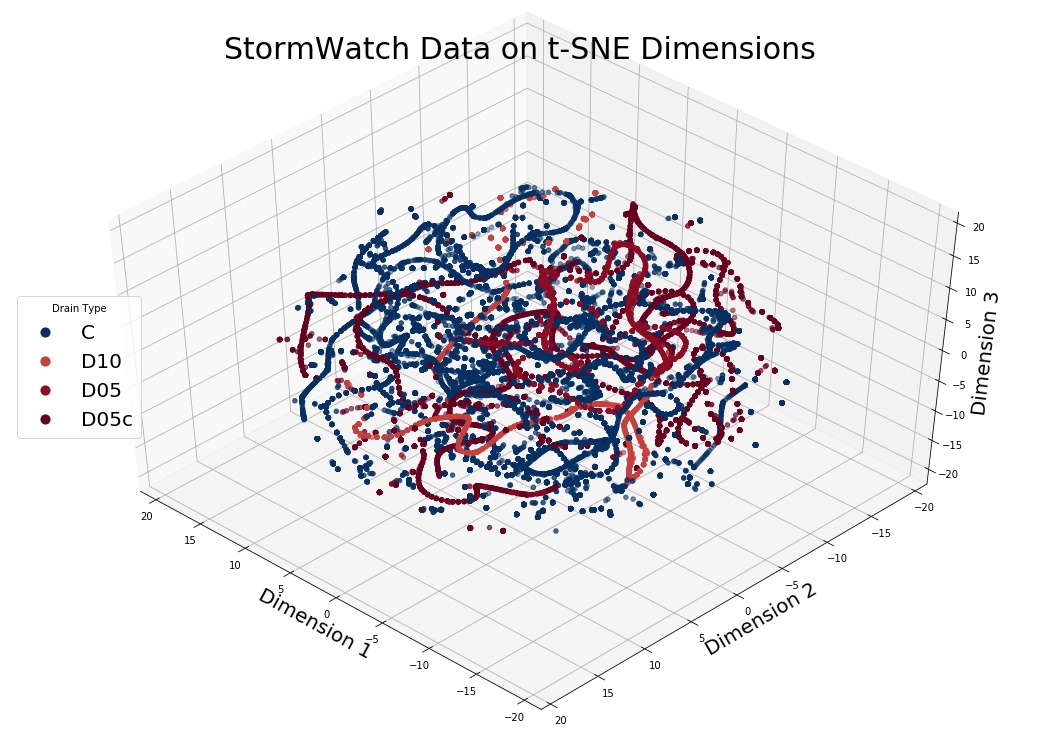

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
# create tuple to match name in legend to profile id
labelTups = [('C', 100), ('D10', 20), ('D05', 10), ('D05c', 5)]
# define the colormap
cmap = plt.cm.RdBu
# create list of colors from profile id
tag = list(df['drain_type_num'])
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
# plot data on tsne components
sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=tag, cmap=cmap)
# assign colors to profile id
colors = [sc.cmap(sc.norm(i)) for i in [100, 20, 10, 5]]
# matplotlib does not support legends for 3D plots, so an empty 2D line plot is created for the legend
custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                mec='k', mfc=c, mew=.1, ms=20) for c in colors]
# plot legend
ax.legend(custom_lines, [lt[0] for lt in labelTups], title='Drain Type', loc='center left', prop={'size': 20})
# title plot and axes
ax.set_xlabel('Dimension 1', fontsize=20)
ax.set_ylabel('Dimension 2', fontsize=20)
ax.set_zlabel('Dimension 3', fontsize=20)
ax.set_title('StormWatch Data on t-SNE Dimensions', fontsize=30)
plt.show()

# Machine learning to predict absorption percentage

In [7]:
# import h2o
import h2o
h2o.init(max_mem_size=80)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/9j/nmg9nt1n0hv2wyylxv2f4_xh0000gn/T/tmp4dyfn5b_
  JVM stdout: /var/folders/9j/nmg9nt1n0hv2wyylxv2f4_xh0000gn/T/tmp4dyfn5b_/h2o_kyleknoebel_started_from_python.out
  JVM stderr: /var/folders/9j/nmg9nt1n0hv2wyylxv2f4_xh0000gn/T/tmp4dyfn5b_/h2o_kyleknoebel_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.6
H2O cluster version age:,"7 days, 20 hours and 40 minutes"
H2O cluster name:,H2O_from_python_kyleknoebel_73uyio
H2O cluster total nodes:,1
H2O cluster free memory:,71.1 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


## Autoencoder on entire dataframe

An [autoencoder](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/) is an unsupervised neural network  model that uses hidden layers of neurons to reduce dimensionality in a dataframe. Like the t-SNE model, the autoencoder is a black box, and transforms the data so variable importance cannot be shown from this model. The autoencoder will be used to find the loss function for further neural network models, and to search for anamolies in the data.  

In [8]:
# shuffle data before split
df = df.sample(frac=1)
# create dataframe for H2O
df_AE = h2o.H2OFrame(df)
# create training, test, validation frames
train,test,valid = df_AE.split_frame(ratios = [0.75, 0.15])
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
# create response and training variables
x = ['runoff_rate_peak_reduction_pct', 'absorb_peak_pct', 'slope_pct', 'rain_in', 'amc_pct', 'vwc_pct', 
     'runoff_trans_in', 'runoff_sheet_in', 'sat_pct', 'runoff_in', 'media_thickness_in', 'retention_thickness_in', 
     'retention_thickness_in', 'profile_max_vwc_pct', 'drain_type_num']

y = 'absorb_delta_in'

AE = H2OAutoEncoderEstimator(activation="rectifierwithdropout", hidden=[15], ignore_const_cols=False, epochs=1000,
                          l1=0, l2=1.0E-5, loss='huber', input_dropout_ratio=0.1, rate=0.2, 
                          stopping_metric='auto', seed=1234, hidden_dropout_ratios=[0.1],  
                          distribution='huber', categorical_encoding='AUTO', elastic_averaging=True,
                          huber_alpha=0.2, max_w2=10.0)
AE.train(x=x, y=y, training_frame=train, validation_frame=valid)
# show error progression
AE._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse,validation_rmse,validation_mse
0,,2019-03-21 17:08:08,1.280 sec,0.00000 obs/sec,0.000000,0,0.0,0.454323,0.206410,0.452683,0.204922
1,,2019-03-21 17:08:13,6.451 sec,157560 obs/sec,32.191163,8,800723.0,0.227364,0.051695,0.226612,0.051353
2,,2019-03-21 17:08:18,11.527 sec,167726 obs/sec,68.394669,17,1701249.0,0.227364,0.051695,0.226612,0.051353
3,,2019-03-21 17:08:23,16.662 sec,170681 obs/sec,104.574696,26,2601191.0,0.227364,0.051695,0.226612,0.051353
4,,2019-03-21 17:08:29,21.959 sec,175420 obs/sec,144.778363,36,3601217.0,0.227364,0.051695,0.226612,0.051353
5,,2019-03-21 17:08:34,27.137 sec,179037 obs/sec,184.975155,46,4601072.0,0.228054,0.052009,0.227253,0.051644
6,,2019-03-21 17:08:39,32.258 sec,181768 obs/sec,225.168288,56,5600836.0,0.227364,0.051695,0.226612,0.051353
7,,2019-03-21 17:08:44,37.497 sec,180410 obs/sec,261.346024,65,6500721.0,0.227364,0.051695,0.226612,0.051353
8,,2019-03-21 17:08:49,42.890 sec,181103 obs/sec,301.558414,75,7500964.0,0.227364,0.051695,0.226612,0.051353
9,,2019-03-21 17:08:55,48.266 sec,181720 obs/sec,341.793640,85,8501775.0,0.227364,0.051695,0.226612,0.051353


### Anomaly exploration with Autoencoder

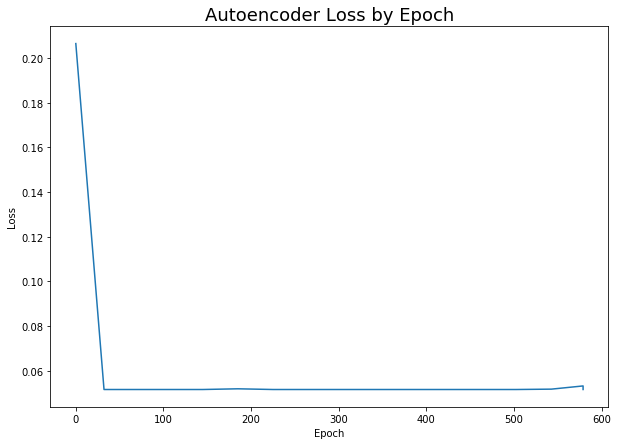

In [9]:
# plotting the loss
plt.figure(figsize=(10, 7))
scoring_history = AE.score_history()
plt.plot(scoring_history['epochs'], scoring_history['training_mse'])
plt.title('Autoencoder Loss by Epoch', fontsize=18)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Plotting the loss function shows that the MSE levels out at about 40 epochs. This will be used in the neural network models below. 

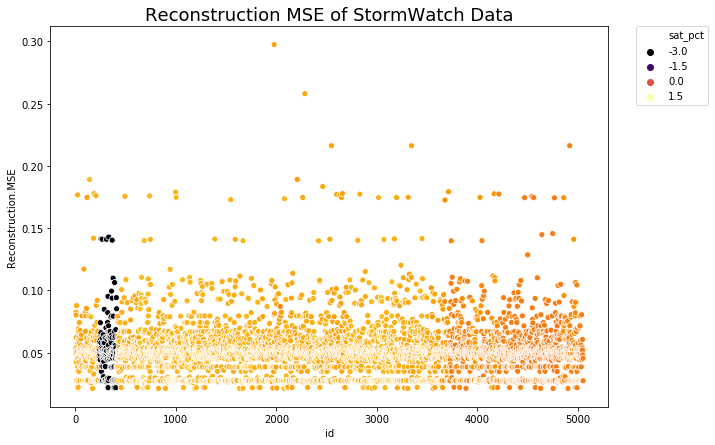

In [10]:
# plot data by MSE
plt.figure(figsize=(10, 7))
test_rec_error = AE.anomaly(test) 
# anomaly is a H2O function which calculates the error for the dataset
# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()
# plotting the testing dataset against the error
test_rec_error_df['id']=test_rec_error_df.index
sns.scatterplot(x='id', y='Reconstruction.MSE', data=test_rec_error_df, hue=df['sat_pct'], 
                palette='inferno')
plt.title('Reconstruction MSE of StormWatch Data', fontsize=18)
# place the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The dots above the large cluster are anamolies in the data. These anamolies may arise from collection errors, errors in data fetching from SQL, etc. Considering there are 33,268 observations in the data, these anamolies should not affect model accuracy.

It should be noted that there is a larger range of error in this MSE REconstruction plot than in the original version. This larger range could be due to the new response variable, or the inclusion of the new drain_type_num and retention_thickness_in variables. 

## Neural network to predict absorption percentage

How do the proposed prediction variables correlate to one another?  

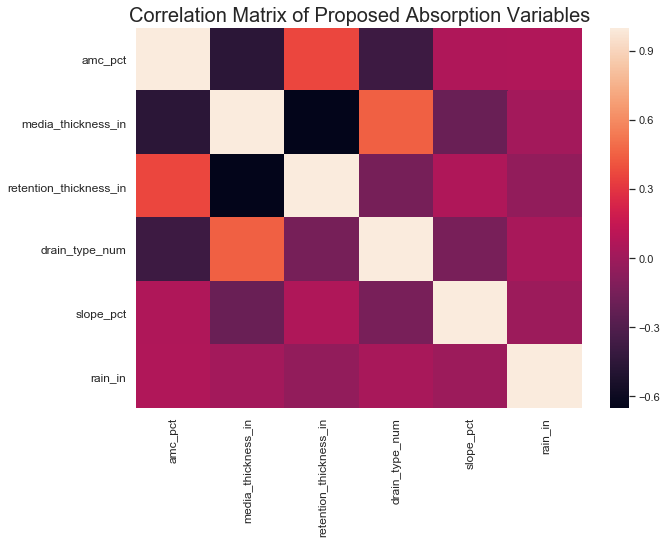

In [11]:
# create a correlation matrix of variables expected to effect absrob_pct
# drop sat_pct as it will not be modeled, only used to create tiers
corr=df[['amc_pct', 'media_thickness_in', 'retention_thickness_in', 'drain_type_num', 'slope_pct', 
         'rain_in']].corr()
# plot as a heatmap
sns.set()
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr)
plt.title('Correlation Matrix of Proposed Absorption Variables', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The heatmap shows some correlation between retention_thickness_in and amc_pct, as well as drain_type_num and media_thickness_in. This correlation is not high enough to skew the model, but should be noted.  

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


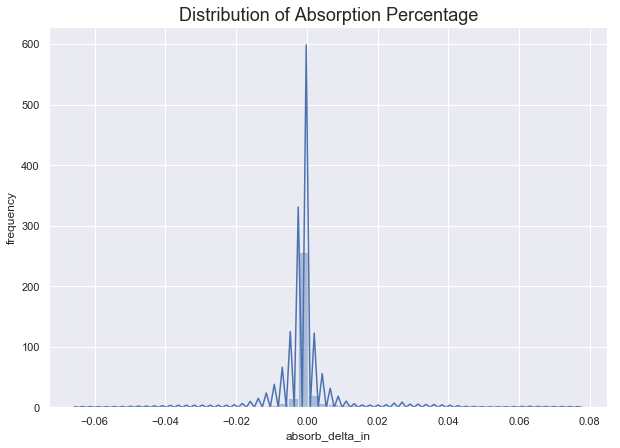

In [12]:
# plot the distribution of the response variable - absorption percentage
plt.figure(figsize=(10, 7))
sns.distplot(df['absorb_delta_in'])
plt.title('Distribution of Absorption Percentage', fontsize=18)
plt.ylabel('frequency')
plt.show()

H2O flow requires the distribution of the response variable as a parameter. Above a Huber distribution is shown for absorb_delta_in. 

### First Tier

In [13]:
print('There are {} rows in the first tier data'.format(len(first_tier)))
print('This is {}% of the total data'.format(((len(first_tier)/len(df))*100)))

There are 238 rows in the first tier data
This is 0.7154021882890466% of the total data


The amount of data in the first tier has increased, but is still less than 1% of the total data. How will the new model run on the first tier data? 

In [14]:
# shuffle data before split
first_tier = first_tier.sample(frac=1)
# create dataframe for H2O
first_tier_model = h2o.H2OFrame(first_tier)
# create training, test, validation frames
first_train,first_test,first_valid = first_tier_model.split_frame(ratios = [0.75, 0.15])
# import deep learning estimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
# create response and training variables
x = ['amc_pct', 'media_thickness_in', 'retention_thickness_in', 'slope_pct', 'rain_in', 'drain_type_num']

y = 'absorb_delta_in'

# deep learning parameters
first_model = H2ODeepLearningEstimator(activation="rectifierwithdropout", hidden=[6, 4], 
                                        epochs=40, l1=0, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.1, rate=0.2, 
                                        stopping_metric='deviance', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.2,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True)
first_model.train(x=x, y=y, training_frame=first_train, validation_frame=first_valid)
# show accuracy
first_model._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-21 17:09:29,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-21 17:09:29,0.072 sec,116000 obs/sec,4.0,1,696.0,0.010588,0.000011,0.005531,0.104297,0.005776,0.000010,0.004234,0.460587
2,,2019-03-21 17:09:29,0.108 sec,210909 obs/sec,40.0,10,6960.0,0.007305,0.000005,0.003949,0.573567,0.004375,0.000005,0.003384,0.690592


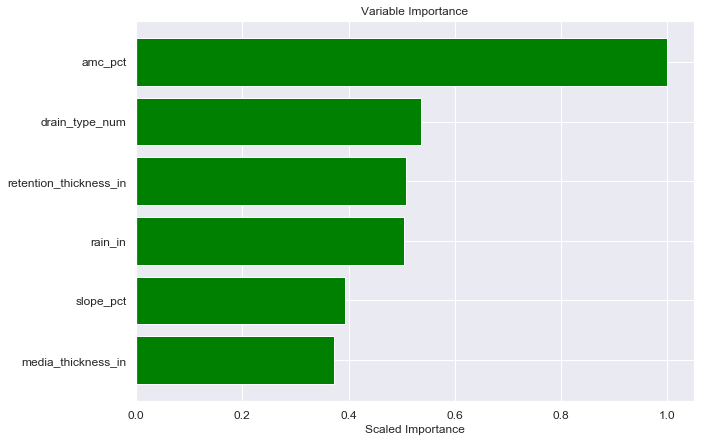

In [15]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = first_model._model_json['output']['variable_importances']['variable']
var = variables[0:6]
y_pos = np.arange(len(var))

scaled_importance = first_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:6]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Interestingly, the model is relatively accurate in the first tier, but imbalanced. The variable importances above may be accurate, but more data is needed in the first tier to ensure this. 

### Second Tier

In [16]:
print('There are {} rows in the second tier data'.format(len(second_tier)))
print('This is {}% of the total data'.format(int((len(second_tier)/len(df))*100)))

There are 5814 rows in the second tier data
This is 17% of the total data


In [17]:
# shuffle data before split
second_tier = second_tier.sample(frac=1)
# create dataframe for H2O
second_tier_model = h2o.H2OFrame(second_tier)
# create training, test, validation frames
second_train,second_test,second_valid = second_tier_model.split_frame(ratios = [0.75, 0.15])
# create response and training variables
x = ['amc_pct', 'media_thickness_in', 'retention_thickness_in', 'slope_pct', 'rain_in', 'drain_type_num']

y = 'absorb_delta_in'

# deep learning parameters
second_model = H2ODeepLearningEstimator(nfolds=3, activation="rectifierwithdropout", hidden=[6, 4], 
                                        epochs=40, l1=0, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.1, rate=0.2, 
                                        stopping_metric='deviance', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.2,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True)
second_model.train(x=x, y=y, training_frame=second_train, validation_frame=second_valid)
# show accuracy
second_model._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-21 17:09:32,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-21 17:09:32,1.219 sec,594833 obs/sec,4.104186,1,17845.0,0.007311,0.000002,0.003066,0.297331,0.007525,0.000002,0.003016,0.271150
2,,2019-03-21 17:09:32,1.438 sec,834197 obs/sec,40.865685,10,177684.0,0.006620,0.000002,0.002667,0.423946,0.007113,0.000002,0.002679,0.348777


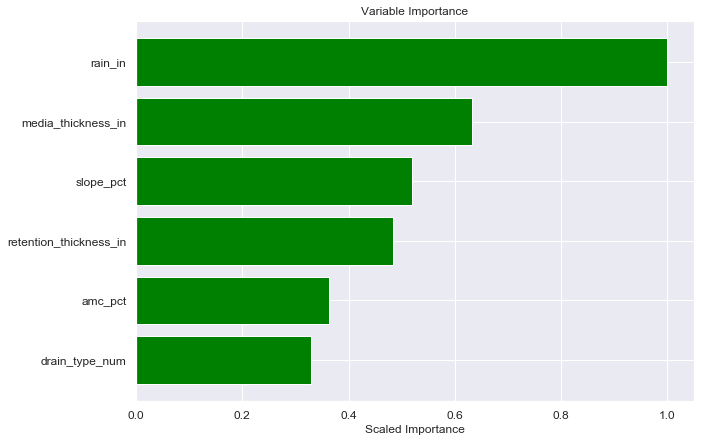

In [18]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = second_model._model_json['output']['variable_importances']['variable']
var = variables[0:6]
y_pos = np.arange(len(var))

scaled_importance = second_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:6]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The second tier shows a good accuracy score and balance. 

### Third Tier

In [19]:
print('There are {} rows in the third tier data'.format(len(third_tier)))
print('This is {}% of the total data'.format(int((len(third_tier)/len(df))*100)))

There are 27216 rows in the third tier data
This is 81% of the total data


In [20]:
# shuffle data before split
third_tier = third_tier.sample(frac=1)
# create dataframe for H2O
third_tier_model = h2o.H2OFrame(third_tier)
# create training, test, validation frames
third_train,third_test,third_valid = third_tier_model.split_frame(ratios = [0.75, 0.15])
# create response and training variables
x = ['amc_pct', 'media_thickness_in', 'retention_thickness_in', 'slope_pct', 'rain_in', 'drain_type_num']

y = 'absorb_delta_in'
# deep learning parameters
third_model = H2ODeepLearningEstimator(nfolds=3, activation="rectifierwithdropout", hidden=[6, 4], 
                                        epochs=40, l1=0, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.1, rate=0.2, 
                                        stopping_metric='deviance', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.2,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                       elastic_averaging=True)
third_model.train(x=x, y=y, training_frame=third_train, validation_frame=third_valid)
# show accuracy
third_model._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-21 17:09:37,0.000 sec,None,0.00000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-21 17:09:37,2.123 sec,786707 obs/sec,4.08339,1,83391.0,0.007675,0.000003,0.003501,0.313600,0.007289,0.000003,0.003303,0.331277
2,,2019-03-21 17:09:38,2.848 sec,1043555 obs/sec,40.87964,10,834844.0,0.007181,0.000003,0.003293,0.399073,0.006692,0.000003,0.003100,0.436385


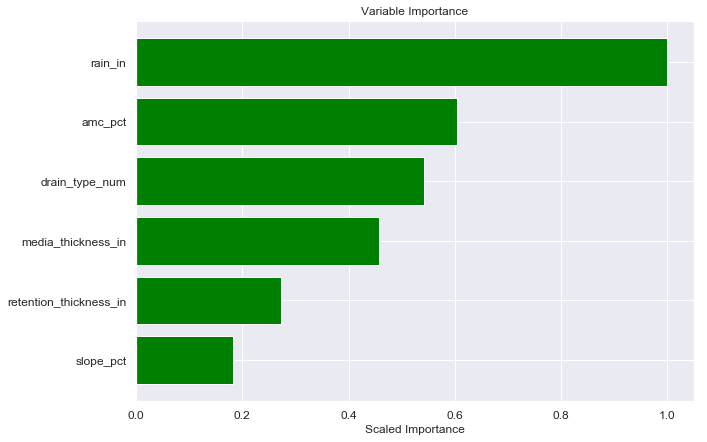

In [21]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = third_model._model_json['output']['variable_importances']['variable']
var = variables[0:6]
y_pos = np.arange(len(var))

scaled_importance = third_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:6]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The third tier model shows better accuracy and balance, likely because this tier has the most data.  

## Model on entire frame

In [22]:
# shuffle data before split
all_data = df.sample(frac=1)
# create dataframe for H2O
all_data_model = h2o.H2OFrame(all_data)
# create training, test, validation frames
all_data_train,all_data_test,all_data_valid = all_data_model.split_frame(ratios = [0.75, 0.15])
# create response and training variables
x = ['runoff_rate_peak_reduction_pct', 'absorb_peak_pct', 'slope_pct', 'rain_in', 'amc_pct', 'vwc_pct', 
     'runoff_trans_in', 'runoff_sheet_in', 'sat_pct', 'runoff_in', 'media_thickness_in', 'retention_thickness_in', 
     'retention_thickness_in', 'profile_max_vwc_pct', 'drain_type_num']

y = 'absorb_delta_in'
# deep learning parameters
all_data_model = H2ODeepLearningEstimator(nfolds=5, activation="rectifierwithdropout", hidden=[15, 10], 
                                        epochs=40, l1=0, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.1, rate=0.2, 
                                        stopping_metric='deviance', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.2,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                       elastic_averaging=True)
all_data_model.train(x=x, y=y, training_frame=all_data_train, validation_frame=all_data_valid)
# show accuracy
all_data_model._model_json['output']['scoring_history'].as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-21 17:09:55,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-21 17:09:55,15.109 sec,254440 obs/sec,3.997082,1,99995.0,0.004489,1.702293e-06,0.001948,0.758714,0.004301,1.818771e-06,0.001960,0.762442
2,,2019-03-21 17:09:59,19.061 sec,255519 obs/sec,43.970620,11,1100013.0,0.003850,7.078324e-07,0.001633,0.822513,0.003858,7.155241e-07,0.001667,0.808862


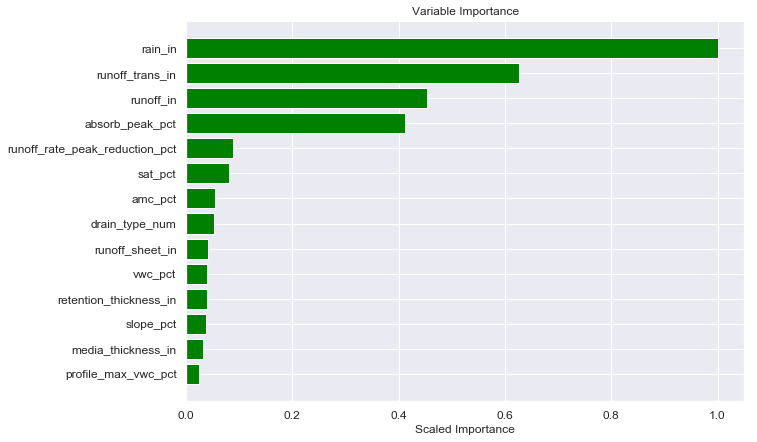

In [23]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = all_data_model._model_json['output']['variable_importances']['variable']
var = variables[0:20]
y_pos = np.arange(len(var))

scaled_importance = all_data_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:20]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

All rainfall instensity and runoff intensity variables are highly correlated to absorb_delta_in. Since the response variable is a measure of the difference between rainfall and runoff, the wieghts of the variables make sense. Also, the amount of rain falling on and flowing out of the profile has a significant effect on  absorption. How does the model work on the entire frame, with only the proposed prediction variables?  

In [24]:
# create response and training variables
x = ['slope_pct', 'rain_in', 'amc_pct', 'media_thickness_in', 'retention_thickness_in', 'drain_type_num']

y = 'absorb_delta_in'
# deep learning parameters
all_data_model_new = H2ODeepLearningEstimator(nfolds=5, activation="rectifierwithdropout", hidden=[6, 4], 
                                        epochs=40, l1=0, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.1, rate=0.2, 
                                        stopping_metric='deviance', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.2,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                       elastic_averaging=True)
all_data_model_new.train(x=x, y=y, training_frame=all_data_train, validation_frame=all_data_valid)
# show accuracy
all_data_model_new._model_json['output']['scoring_history'].as_data_frame()

deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-21 17:10:04,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-21 17:10:04,4.363 sec,892812 obs/sec,3.997082,1,99995.0,0.007572,0.000004,0.003510,0.313526,0.007193,0.000004,0.003425,0.335461
2,,2019-03-21 17:10:05,5.321 sec,1046634 obs/sec,43.970620,11,1100013.0,0.007049,0.000003,0.003226,0.405107,0.006551,0.000003,0.003121,0.448902


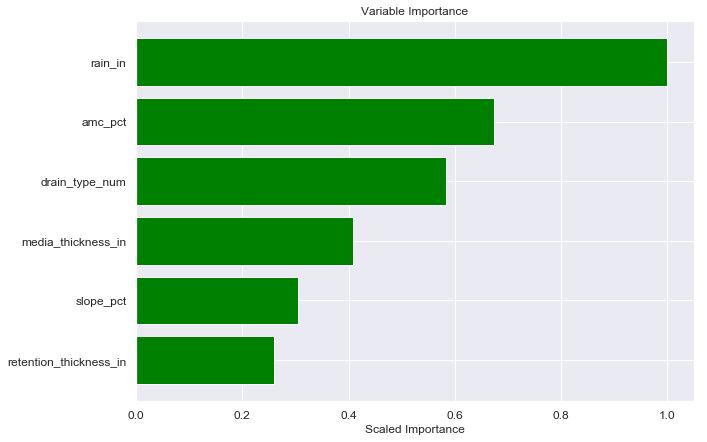

In [25]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = all_data_model_new._model_json['output']['variable_importances']['variable']
var = variables[0:20]
y_pos = np.arange(len(var))

scaled_importance = all_data_model_new._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:20]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The model's accuracy drops when only using the proposed predictors, but is balanced. The effect of this change will be discussed more below, but it should be noted that there are more factors that affect absorption than the proposed predictors. 

## Plotting the effect of drain type on absorption

The drain type is the type of drainage layer associated with each roofing profile. As such, a drain type that detains or slows absorption would likely increase absorption of water into the media layer. How does each drain type affect absorption?

To further understand this, the amount of runoff in each increment will be plotted against the predicted absorption (in absorb_delta_in) for each drain type.

deeplearning prediction progress: |███████████████████████████████████████| 100%


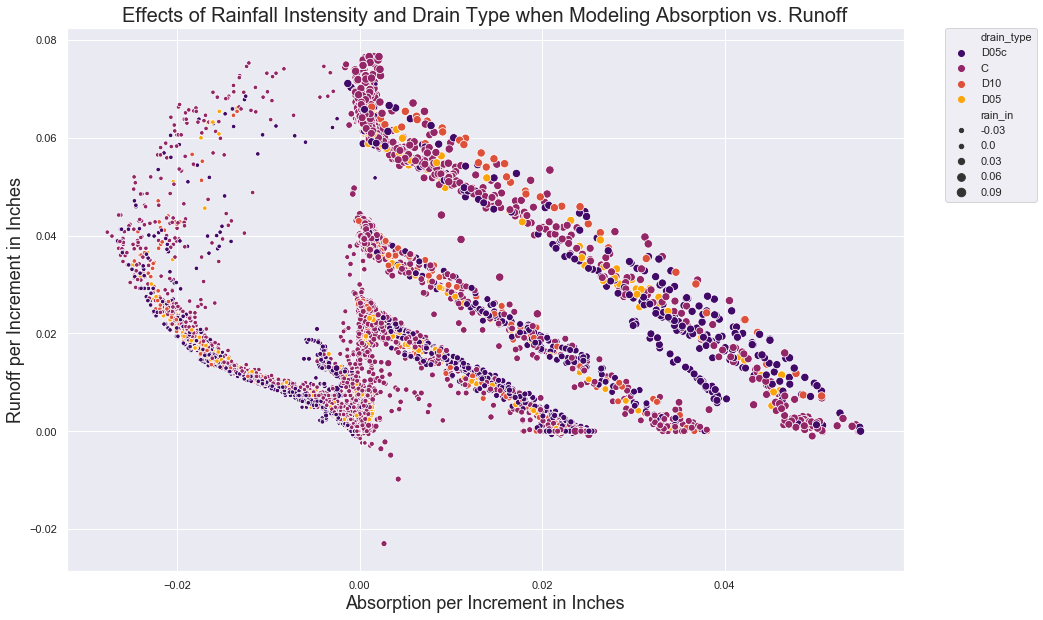

In [38]:
# get the predicted absorb_delta_in values 
predictions = all_data_model.predict(all_data_train)
df_predictions = predictions.as_data_frame()
# convert training data to pandas
df_all_data_train = all_data_train.as_data_frame()
# concatenate the predicted absorption onto pandas frame
df_all_data_train = pd.concat([df_all_data_train, df_predictions], 1)
# there is one outlier in the data that skews the visualization that will be dropped
df_all_data_train = df_all_data_train[~(df_all_data_train.iloc[:, 50] < -0.05)]
# plot runoff_in vs. predicted absorption 
plt.figure(figsize=(15, 10))
sns.scatterplot(x='predict', y='runoff_in', hue='drain_type', size = 'rain_in', 
                data=df_all_data_train, palette='inferno')
# title and label axes
plt.title('Effects of Rainfall Instensity and Drain Type when Modeling Absorption vs. Runoff', size=20)
plt.xlabel('Absorption per Increment in Inches', size=18)
plt.ylabel('Runoff per Increment in Inches', size=18)
# place the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

With the exception of a few outliers, this plot shows some interesting trends on either side of the y axis. On the left side of the plot, we can see that as absorption decreases, there is a curved relationship to runoff. Meanwhile, the right side of the y axis shows some clustering.

The size of each observation relates to rainfall instensity per increment. Again with the exception of a few outliers, the observation size shows that the clusters relate to rainfall intensity. The data is collected from a number of different tests with different rainfall intensities, which explains this clustering. 

There is little to no clustering when absorption is below 0. More testing would need to be done on absorption below 0 (or drainage) in order to show if clustering occurs, but it seems the observations are following a curve rather than creating clusters. All observations on this side of the y axis also show low rainfall intensities, so it seems when water drains from a profile it reaches a limit where it no longer runs off the profile and starts absorbing into the media. 

On the right side of the axis, some clustering can be seen. One aspect of this section to note is that drain type C tends to cluster towards 0, showing that this drain type has the most negative effect on absorption. Drain type C also groups at the high end of absorption under high and medium rainfall intensities. 

The other drain types are designed to slow the flow of the water from the profile, so it would makes sense that these types trend towards higher absorption. At first glance, drain types D05c and C seem to increase absorption at high rainfall intensities, while all drain types have similar effects on absorption at medium to lower intensities. Drain type D05c also groups by itself under a rainfall instensity separate from the other types, modet likely becasue of a test run only on this drain type.

# Variable tinkering - what happens when unimportant variables are removed?

This section will explore the outcomes of removing variables from the bottom of the importance lists. This will be done for each tier and the entire frame to find which variables are most important to each group.   

## First tier

The first tier shows good accuracy, so what we are looking for here is any improvement/loss in the accuracy or balance when removing variables. Both slope_pct and media_thickness_in have weights below 50%, but media_thickness_in is correlated to drain_type_num, so only slope_pct will be removed. 

In [27]:
# create response and training variables
x = ['amc_pct', 'media_thickness_in', 'retention_thickness_in', 'rain_in', 'drain_type_num']

y = 'absorb_delta_in'

# deep learning parameters
first_model_tinker = H2ODeepLearningEstimator(activation="rectifierwithdropout", hidden=[5, 3], 
                                        epochs=40, l1=0, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.1, rate=0.2, 
                                        stopping_metric='deviance', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.2,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True)
first_model_tinker.train(x=x, y=y, training_frame=first_train, validation_frame=first_valid)
# show accuracy
first_model_tinker._model_json['output']['scoring_history'].as_data_frame()

deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-21 17:10:09,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-21 17:10:09,0.028 sec,348000 obs/sec,4.0,1,696.0,0.012474,0.000021,0.006752,-0.243398,0.010415,0.000019,0.006117,-0.753652
2,,2019-03-21 17:10:09,0.047 sec,435000 obs/sec,40.0,10,6960.0,0.010065,0.000015,0.005647,0.190497,0.006710,0.000011,0.004707,0.272068


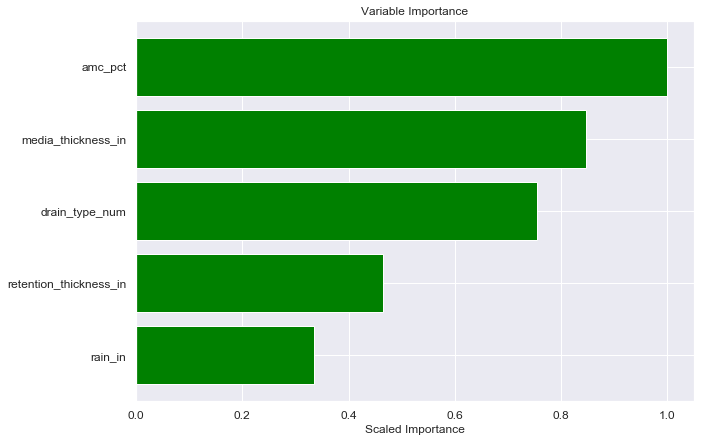

In [28]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = first_model_tinker._model_json['output']['variable_importances']['variable']
var = variables[0:6]
y_pos = np.arange(len(var))

scaled_importance = first_model_tinker._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:6]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The accuracy of the model dropped significantly when slope_pct is removed, and the variables shuffled their importance. All variables should be included in modeling for the first tier.  

## Second tier

amc_pct and retention_thickness are correlated, so removing these two variables at once should not affect the entire model. amc_pct, retention_thickness_in and slope_pct also all have weights below 50%, so all three can be removed.  

In [29]:
# create response and training variables
x = ['rain_in', 'drain_type_num', 'media_thickness_in']

y = 'absorb_delta_in'

# deep learning parameters
second_model_tinker = H2ODeepLearningEstimator(activation="rectifierwithdropout", hidden=[3, 1], 
                                        epochs=40, l1=0, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.1, rate=0.2, 
                                        stopping_metric='deviance', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.2,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True)
second_model_tinker.train(x=x, y=y, training_frame=second_train, validation_frame=second_valid)
# show accuracy
second_model_tinker._model_json['output']['scoring_history'].as_data_frame()

deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-21 17:10:09,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-21 17:10:09,0.031 sec,1932444 obs/sec,4.0,1,17392.0,0.007446,0.000003,0.002978,0.271296,0.007586,0.000002,0.002930,0.259265
2,,2019-03-21 17:10:09,0.108 sec,2288421 obs/sec,40.0,10,173920.0,0.007059,0.000004,0.002837,0.345007,0.007345,0.000004,0.002827,0.305469
3,,2019-03-21 17:10:09,0.118 sec,2258701 obs/sec,40.0,10,173920.0,0.007446,0.000003,0.002978,0.271296,0.007586,0.000002,0.002930,0.259265


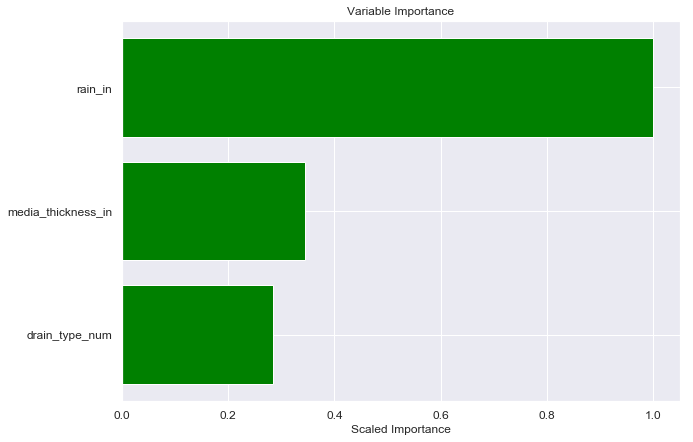

In [30]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = second_model_tinker._model_json['output']['variable_importances']['variable']
var = variables[0:6]
y_pos = np.arange(len(var))

scaled_importance = second_model_tinker._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:6]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The model lost accuracy somewhat when amc_pct, slope_pct and retention_thickness_in are removed. The three variables above are most likely the most important to absorption in the second tier. 

## Third tier

slope_pct and retention_thickness_in have the lowest weight in the third tier. These variables will be removed, but since retention_thickness_in is correlated to amc_pct it should be noted what happens to this variable. 

In [31]:
# create response and training variables
x = ['amc_pct', 'media_thickness_in', 'rain_in', 'drain_type_num']

y = 'absorb_delta_in'

# deep learning parameters
third_model_tinker = H2ODeepLearningEstimator(activation="rectifierwithdropout", hidden=[4, 2], 
                                        epochs=40, l1=0, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.1, rate=0.2, 
                                        stopping_metric='deviance', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.2,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                        elastic_averaging=True)
third_model_tinker.train(x=x, y=y, training_frame=first_train, validation_frame=first_valid)
# show accuracy
third_model_tinker._model_json['output']['scoring_history'].as_data_frame()

deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-21 17:10:09,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-21 17:10:09,0.018 sec,348000 obs/sec,4.0,1,696.0,0.010658,0.000018,0.006220,0.092427,0.007094,0.000015,0.005277,0.186473
2,,2019-03-21 17:10:09,0.031 sec,632727 obs/sec,40.0,10,6960.0,0.007197,0.000008,0.003871,0.586179,0.004040,0.000006,0.003361,0.736128


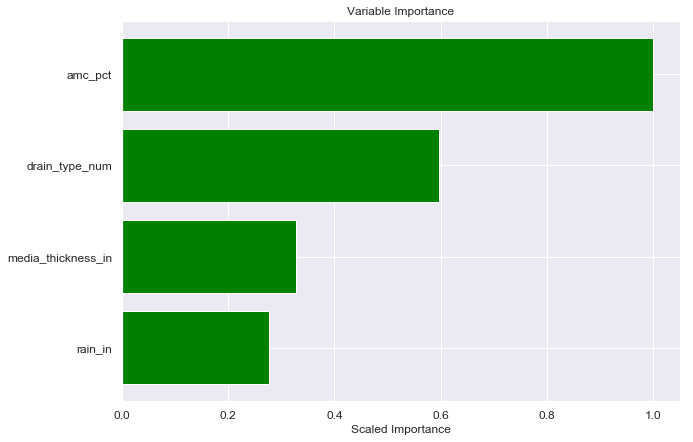

In [32]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = third_model_tinker._model_json['output']['variable_importances']['variable']
var = variables[0:6]
y_pos = np.arange(len(var))

scaled_importance = third_model_tinker._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:6]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Interestingly the amc_pct becomes the most important variable when slope_pct and retention_thickness_in are removed from the model. It is possible that slope_pct and retention_thickness_in are important to the amc_pct in this tier, meaning these variables could be used to predict the moisture content of the following increment when saturation percentage is above 66%. Since the accuracy score increases in this model, these variables are the most important to absorption in the third tier.

## Entire frame

The entire frame has similar variable importances to the third tier above. Since the majority of the data comes from this tier, the similarities make sense. 

In [33]:
# create response and training variables
x = ['rain_in', 'amc_pct', 'media_thickness_in', 'drain_type_num']

y = 'absorb_delta_in'
# deep learning parameters
all_data_model_tinkered = H2ODeepLearningEstimator(nfolds=5, activation="rectifierwithdropout", hidden=[6, 4], 
                                        epochs=40, l1=0, l2=1.0E-5, 
                                        loss='huber', input_dropout_ratio=0.1, rate=0.2, 
                                        stopping_metric='deviance', shuffle_training_data = True, 
                                        hidden_dropout_ratios=[0.1, 0.1], huber_alpha=0.2,  
                                        seed=1234, distribution='huber', ignore_const_cols=True,
                                       elastic_averaging=True)
all_data_model_tinkered.train(x=x, y=y, training_frame=all_data_train, validation_frame=all_data_valid)
# show accuracy
all_data_model_tinkered._model_json['output']['scoring_history'].as_data_frame()

deeplearning Model Build progress: |██████████████████████████████████████| 100%


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2019-03-21 17:10:13,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-03-21 17:10:13,3.390 sec,980343 obs/sec,3.997082,1,99995.0,0.00740,0.000004,0.003560,0.344354,0.006983,0.000004,0.003471,0.373683
2,,2019-03-21 17:10:14,4.163 sec,1292612 obs/sec,43.970620,11,1100013.0,0.00722,0.000004,0.003448,0.375859,0.006757,0.000004,0.003364,0.413637


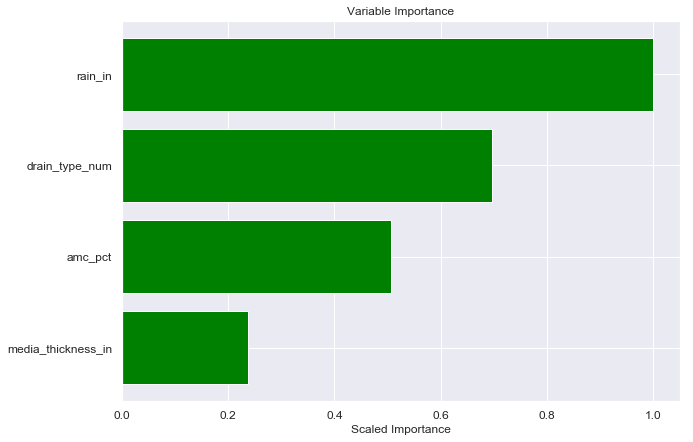

In [34]:
# plotting the variable importance
#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10, 7))

variables = all_data_model_tinkered._model_json['output']['variable_importances']['variable']
var = variables[0:6]
y_pos = np.arange(len(var))

scaled_importance = all_data_model_tinkered._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:6]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The model does not lose much accuracy when retention_thickness_in and slope_pct are removed. Aside from the runoff variables, rain_in, amc_pct and drain_type are the most important to absorption in the entire frame. 

# Summary

This report shows that modeling for absorption improves significantly when absorption is measured in inches. The first tier shows less accuracy than the others, but as more data is collected for this tier the accuracy will likely improve. Rainfall intensity and drainage type seem the most important to absorption across all data, and except for the second tier AMC plays a large role in absorption.  

The importance of the drainage layer to absorption is shown by the plot of runoff vs. absorption. More testing should be done on the effect of each drainage layer on absorption, but drainage layers that increase detention seem to have the most effect at medium to low rainfall instensities. Of all drainage layers designed for detention, D05c has the higest effect on absorption under high rainfall instensity.   

The variable tinkering shows that all variables are important in the first tier, possibly illustrating that dry soil is the most affected by all variables. AMC seems to have the least effect on absorption in the second tier when compared to others, with rainfall intensity having the greatest effect in tier two. As saturation increases over 66%, AMC and the drainage layer have the most effect on absorption. It is possible that the slope % and thickness of the retention layer can be used to predict the AMC in the successive increment of a storm when saturation is above 66%.

The model on the entire frame is the most accurate and balanced when all variables collected from the DQL database are modeled. This fact shows that variables not accounted for in the proposed prediction variables set are affecting absorption. Once more data is collected on plant health, capillarity and permeability, these variables should be modeled to see if they have an effect greater than the rainfall/runoff variables.    